In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import zarr
import numpy as np


file_path = '/data/tv_chambolle_data.csv'
df = pd.read_csv(file_path)

In [2]:
def extract_from_dict_column(column, key):
    return column.apply(lambda x: ast.literal_eval(x)['args'].get(key) if pd.notnull(x) else None)

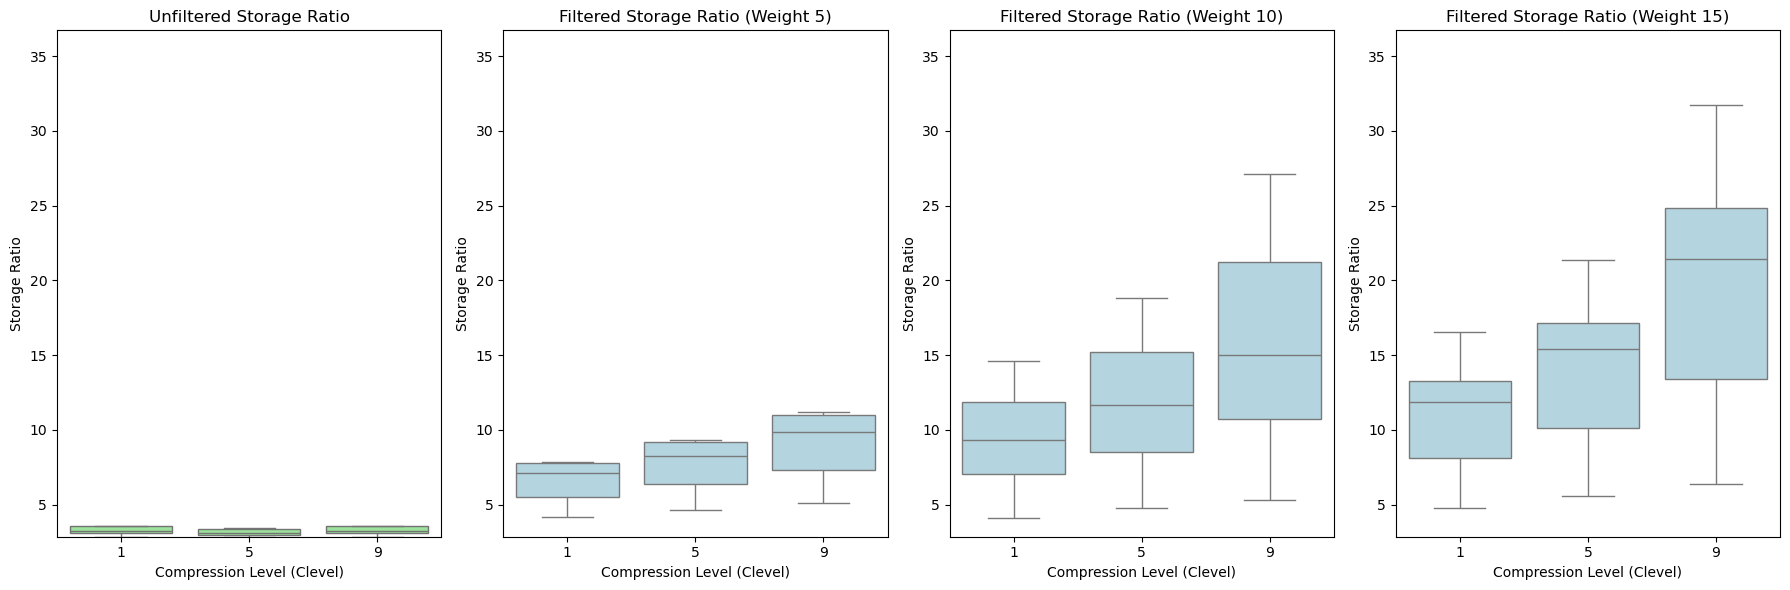

In [3]:
df['clevel'] = df['codec_params'].apply(lambda x: ast.literal_eval(x)['clevel'])
df['weight'] = extract_from_dict_column(df['filter_params'], 'weight')

# Convert footprint to string for plotting
# df['footprint_str'] = df['footprint'].astype(str)

# Set the same y-axis range for all subplots (unfiltered and filtered)
y_min = min(df['filtered_storage_ratio'].min(), df['unfiltered_storage_ratio'].min())
y_max = max(df['filtered_storage_ratio'].max(), df['unfiltered_storage_ratio'].max()) + 5

# Set up the plotting environment for three side-by-side plots
plt.figure(figsize=(18, 6))

# 1. Unfiltered storage ratios plot
plt.subplot(1, 4, 1)
sns.boxplot(x='clevel', y='unfiltered_storage_ratio', data=df, color='lightgreen')
plt.title('Unfiltered Storage Ratio')
plt.ylabel('Storage Ratio')
plt.xlabel('Compression Level (Clevel)')
plt.ylim(y_min, y_max)

# 2. Filtered storage ratios for footprint 1
plt.subplot(1, 4, 2)
sns.boxplot(x='clevel', y='filtered_storage_ratio', data=df[df['weight'] == 5], color='lightblue')
plt.title(f'Filtered Storage Ratio (Weight 5)')
plt.ylabel('Storage Ratio')
plt.xlabel('Compression Level (Clevel)')
plt.ylim(y_min, y_max)

plt.subplot(1, 4, 3)
sns.boxplot(x='clevel', y='filtered_storage_ratio', data=df[df['weight'] == 10], color='lightblue')
plt.title(f'Filtered Storage Ratio (Weight 10)')
plt.ylabel('Storage Ratio')
plt.xlabel('Compression Level (Clevel)')
plt.ylim(y_min, y_max)

plt.subplot(1, 4, 4)
sns.boxplot(x='clevel', y='filtered_storage_ratio', data=df[df['weight'] == 15], color='lightblue')
plt.title(f'Filtered Storage Ratio (Weight 15)')
plt.ylabel('Storage Ratio')
plt.xlabel('Compression Level (Clevel)')
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Weight 15, storage ratio = 11.6')

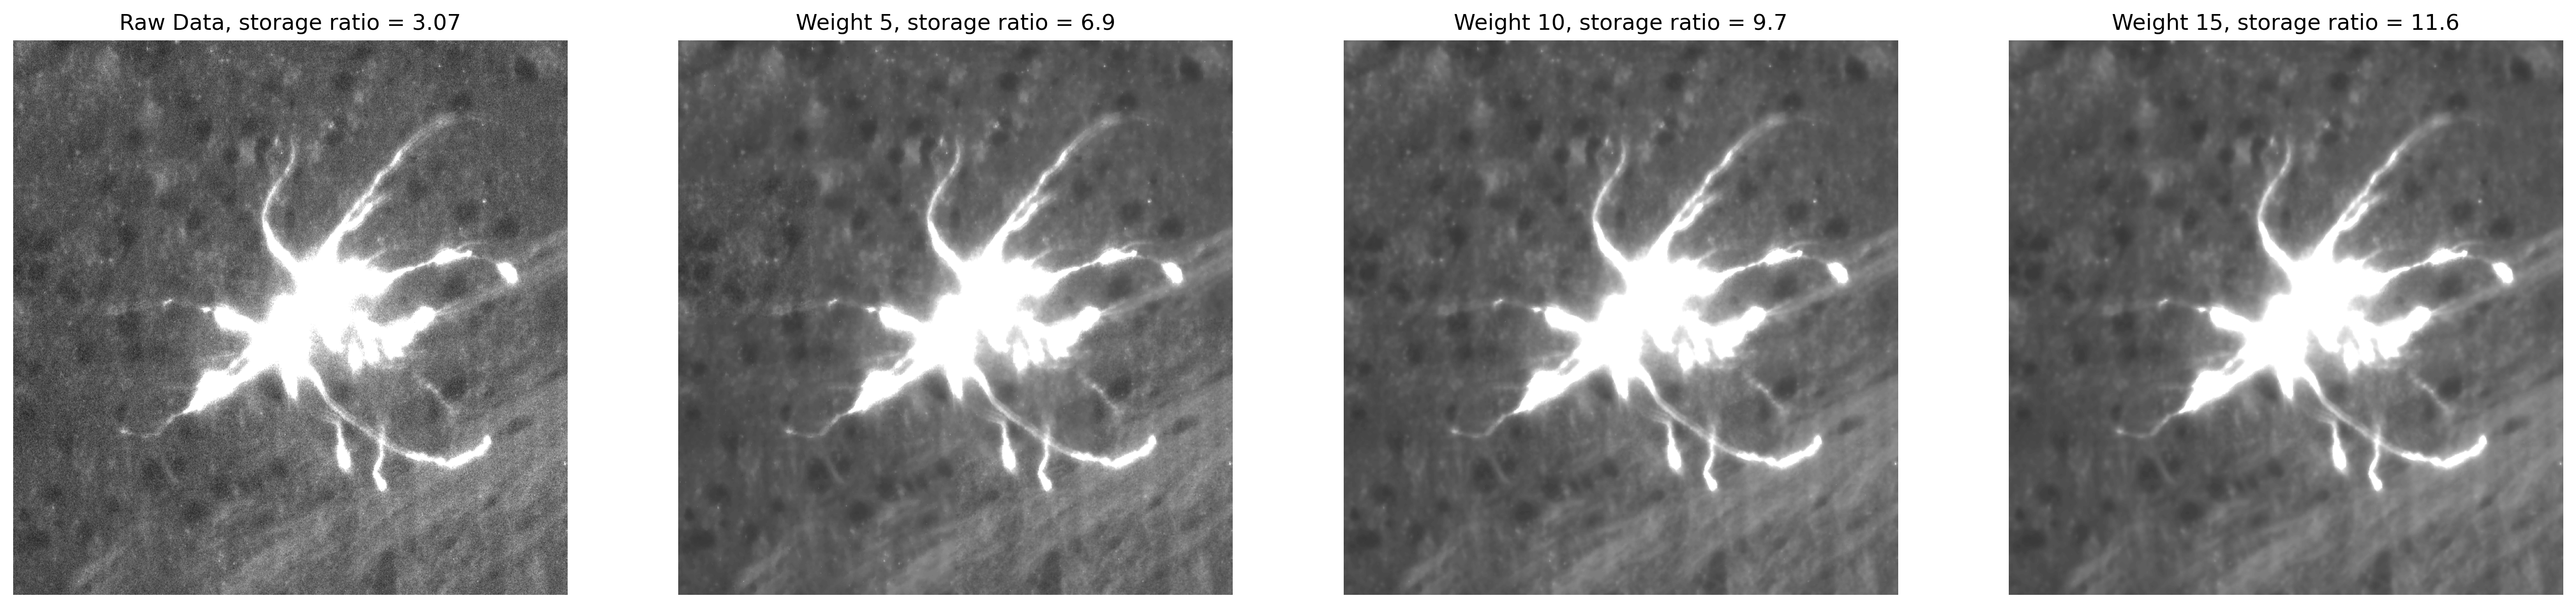

In [4]:
raw = "s3://aind-msma-morphology-data/training-data/exaSPIM_706301/block_002/block_002.zarr"
w5 = "/root/capsule/results/block_002/block_002_18.zarr"
w10 = "/root/capsule/results/block_002/block_002_21.zarr"
w15 = "/root/capsule/results/block_002/block_002_24.zarr"

s = 621

zraw = zarr.open(raw, 'r')['0'][0,0,s,...]
z5 = zarr.open(w5, 'r')[s]
z10 = zarr.open(w10, 'r')[s]
z15 = zarr.open(w15, 'r')[s]

plt.figure(figsize=(25, 15), dpi=300)

# 1. Unfiltered storage ratios plot
plt.subplot(1, 4, 1)
plt.imshow(zraw, cmap='gray', vmin=0, vmax=100)
plt.axis('off')
plt.title("Raw Data, storage ratio = 3.07")

plt.subplot(1,4,2)
plt.imshow(z5, cmap='gray', vmin=0, vmax=100)
plt.axis('off')
plt.title("Weight 5, storage ratio = 6.9")

plt.subplot(1,4,3)
plt.imshow(z10, cmap='gray', vmin=0, vmax=100)
plt.axis('off')
plt.title("Weight 10, storage ratio = 9.7")

plt.subplot(1,4,4)
plt.imshow(z15, cmap='gray', vmin=0, vmax=100)
plt.axis('off')
plt.title("Weight 15, storage ratio = 11.6")

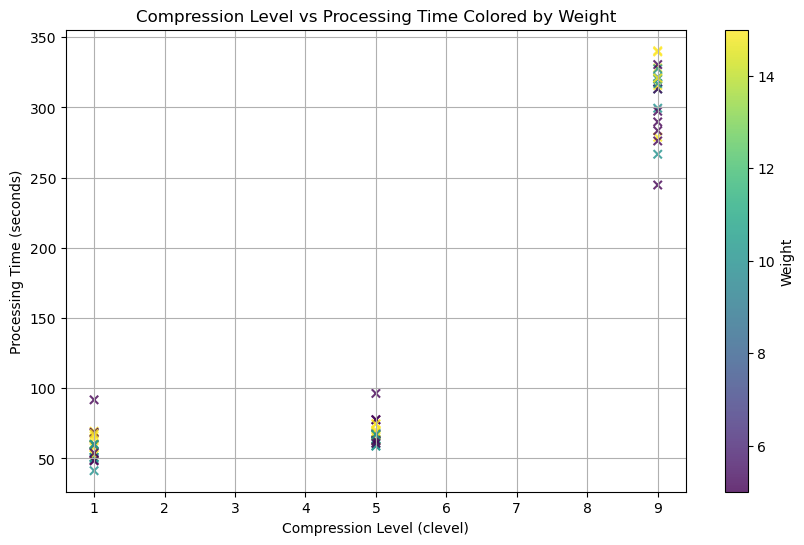

In [5]:
# Create a scatter plot of compression level versus processing time, colored by weight
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['clevel'], df['process_time'], c=df['weight'], cmap='viridis', alpha=0.8, marker='x')
plt.xlabel('Compression Level (clevel)')
plt.ylabel('Processing Time (seconds)')
plt.title('Compression Level vs Processing Time Colored by Weight')
plt.colorbar(sc, label='Weight')
plt.grid(True)
plt.show()


In [18]:
weight = 10
clevel = 5

data = df[(df['weight'] == weight) & (df['clevel'] == clevel)]

avg_time = data['process_time'].mean()
print(f"Average processing time for weight {weight} and clevel {clevel}: {avg_time:.2f}s")

avg_speed = (data['in_bytes'] / data['process_time']).mean() / 1024**2
print(f"Average processing speed: {avg_speed:.2f}MiB/s")

tile_shape = (26624, 10640, 14192)
tile_mbytes = (np.prod(tile_shape) * 2) / 1024**2
tile_process_time = tile_mbytes / avg_speed / 60 / 60
print(f"Full tile MBytes: {tile_mbytes}")
print(f"Full tile processing time (hr): {tile_process_time:.2f}")

instance_cost = 0.526  # per hour
tile_process_cost = instance_cost * tile_process_time
print(f"Full tile processing cost (upper bound): ${tile_process_cost:.2f}")

print(f"Full brain processing cost: ${tile_process_cost * 15:.2f}")

Average processing time for weight 10 and clevel 5: 63.44s
Average processing speed: 32.40MiB/s
Full tile MBytes: 7668115.0
Full tile processing time (hr): 65.75
Full tile processing cost (upper bound): $34.58
Full brain processing cost: $518.75
